In [1]:
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use('ggplot')

# 1. 
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before

***

$$Pr(p \mid n, k) = \frac{Pr(k \mid n, p) * Pr(p)}{Pr(n, k)}$$

where, 
* $p$ is the proportion of earth covered in water
* $n$ is the number of times the globe was tossed
* $k$ is the number of times the right index finger lands on a water body 

#### Step 1: Creating grid for approximating $p$

In [3]:
p_grid = np.linspace(start=0, stop=1, num=101)
# plt.plot(p_grid, 'r.');

#### Step 2: Calculating posterior


$$
posterior = \frac{liklihood * prior}{\sum (liklihood * prior)}
$$

In [4]:
n = 15 
k = 8

In [5]:
prior = pm.Uniform.dist(low=1., high=1.).sample_numpy(shape=p_grid.shape[0])
liklihood = (np.exp(pm.Binomial.dist(total_count=n, probs=p_grid).log_prob_numpy(value=k)))

In [6]:
unstandardised_posterior = liklihood * prior

# standardised_posterior
posterior = unstandardised_posterior / sum(unstandardised_posterior) 

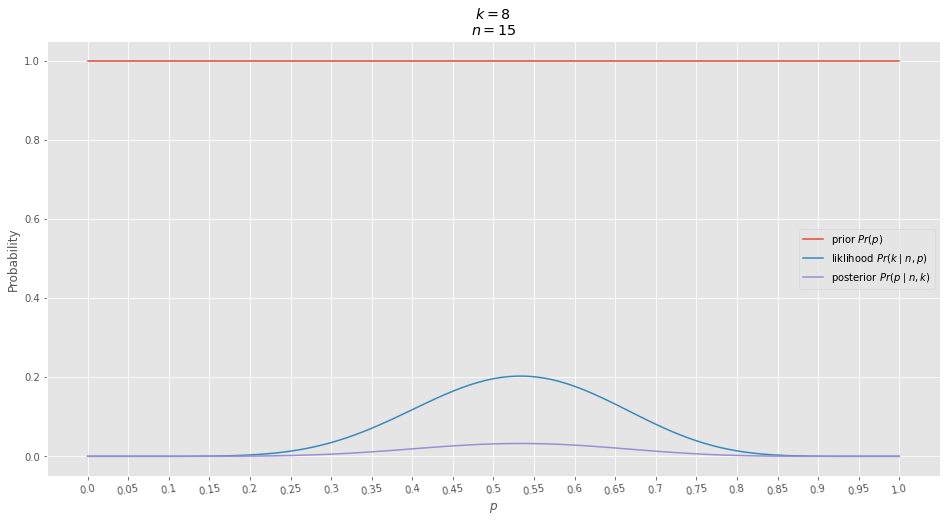

In [7]:
plt.plot(prior, label='prior $Pr(p)$');
plt.plot(liklihood, label='liklihood $Pr(k \mid n, p)$');
plt.plot(posterior, label='posterior $Pr(p \mid n, k)$');
plt.legend();
plt.xticks(ticks=np.arange(0, p_grid.shape[0], 5), labels=p_grid[::5].round(2), rotation=10);
plt.xlabel('$p$');
plt.ylabel('Probability');
plt.title(f'$k={k}$\n$n={n}$');

#### Step 3: Sampling from the posterior

In [8]:
samples = np.random.choice(a=p_grid, size=5000, p=posterior)

#### Step 4: Calculating intervals

In [9]:
## 99th Percentile interval
np.percentile(a=samples, q=[0.5, 99.5])
# np.quantile(a=samples, q=[0.005, 0.995])

array([0.24995, 0.81   ])

In [10]:
## 99th HPD interval
az.hpd(samples, credible_interval=0.99)

array([0.24, 0.8 ])

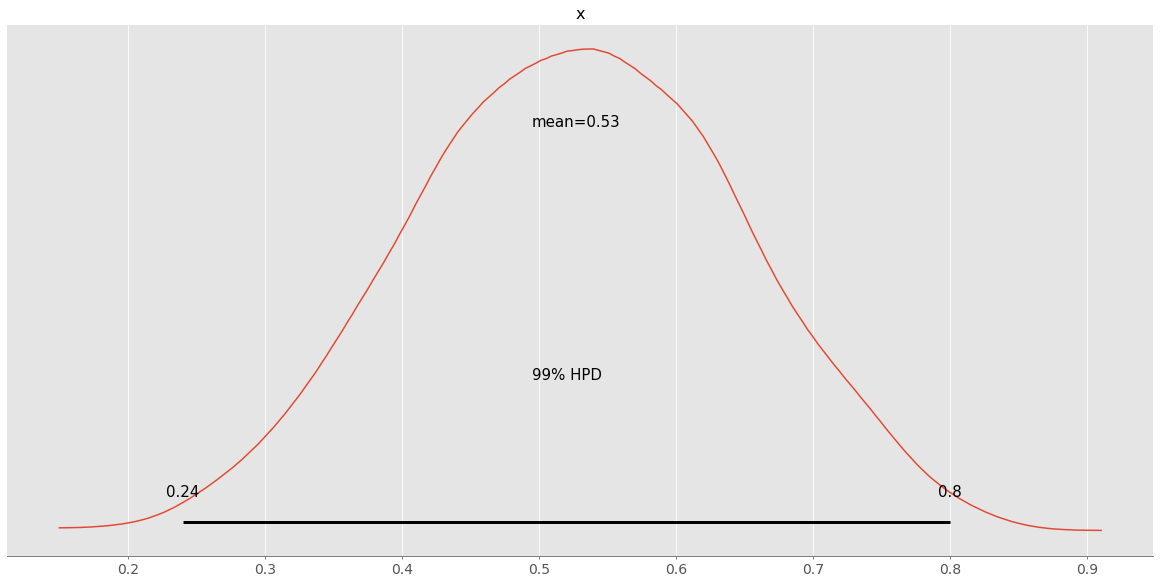

In [11]:
az.plot_posterior(samples, credible_interval=0.99);

# 2. 
Start over in 1, but now use a prior that is zero below $p = 0.5$ and a constant above $p = 0.5$. This corresponds to prior information that a majority of the Earth’s surface is water. What difference does the better prior make? If it helps, compare posterior distributions (using both priors) to the true
value $p = 0.7$.

***

$$Pr(p \mid n, k) = \frac{Pr(k \mid n, p) * Pr(p)}{Pr(n, k)}$$

where, 
* $p$ is the proportion of earth covered in water
* $n$ is the number of times the globe was tossed
* $k$ is the number of times the right index finger lands on a water body 

#### Step 1: Creating grid for approximating $p$

In [12]:
p_grid = np.linspace(start=0, stop=1, num=101)

#### Step 2: Calculating posterior


$$
posterior = \frac{liklihood * prior}{\sum (liklihood * prior)}
$$

In [13]:
n = 15 
k = 8

In [14]:
prior = np.repeat(a=[0, 1], repeats=p_grid.shape[0]/2 + 1)[:p_grid.shape[0]]
liklihood = (np.exp(pm.Binomial.dist(total_count=n, probs=p_grid).log_prob_numpy(value=k)))

In [15]:
unstandardised_posterior = liklihood * prior

# standardised_posterior
posterior = unstandardised_posterior / sum(unstandardised_posterior) 

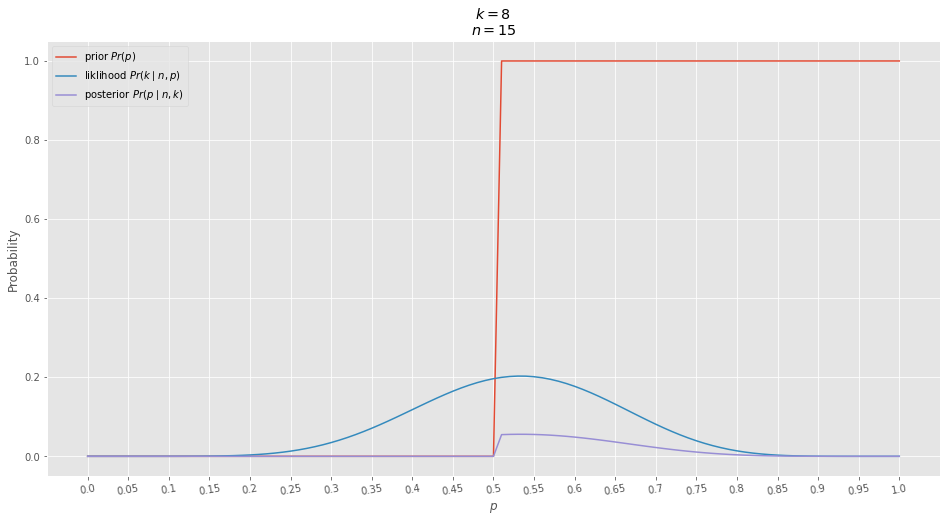

In [16]:
plt.plot(prior, label='prior $Pr(p)$');
plt.plot(liklihood, label='liklihood $Pr(k \mid n, p)$');
plt.plot(posterior, label='posterior $Pr(p \mid n, k)$');
plt.legend();
plt.xticks(ticks=np.arange(0, p_grid.shape[0], 5), labels=p_grid[::5].round(2), rotation=10);
plt.xlabel('$p$');
plt.ylabel('Probability');
plt.title(f'$k={k}$\n$n={n}$');

#### Step 3: Sampling from the posterior

In [17]:
samples = np.random.choice(a=p_grid, size=5000, p=posterior)

#### Step 4: Calculating intervals

In [18]:
## 99th Percentile interval
np.percentile(a=samples, q=[0.5, 99.5])
# np.quantile(a=samples, q=[0.005, 0.995])

array([0.51, 0.83])

In [19]:
## 99th HPD interval
az.hpd(samples, credible_interval=0.99)

array([0.51, 0.8 ])

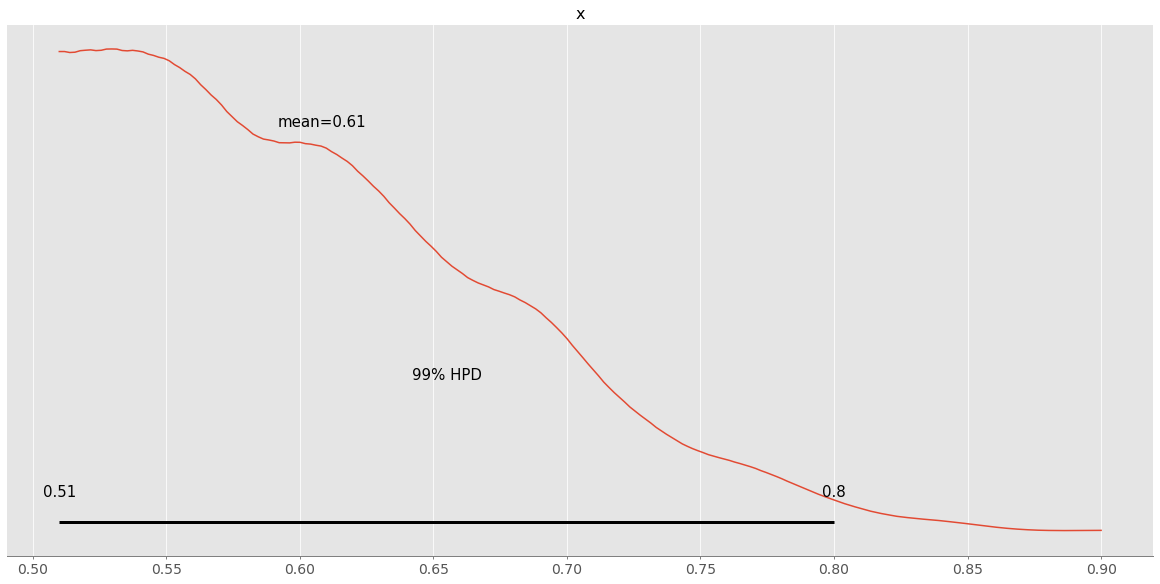

In [20]:
az.plot_posterior(samples, credible_interval=0.99);

# 3. 
This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this? I won’t require a precise answer. I’m honestly more interested in your approach

***

We want that $p_{0.995}$ - $p_{0.005}$ $\le$ 0.05

The data will get more precise with more number of trials $n$. 

In [21]:
p_true = 0.7

samples_list = []
n_trials = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

for i, n in enumerate(n_trials):
    generated_data = pm.Binomial.dist(total_count=n, probs=p_true).sample_numpy()
    p_grid = np.linspace(start=0, stop=1, num=1001)
    prior = pm.Uniform.dist(low=1., high=1.).sample_numpy(shape=p_grid.shape[0])
    liklihood = (np.exp(pm.Binomial.dist(total_count=n, probs=p_grid).log_prob_numpy(value=generated_data)))
    unstandardised_posterior = liklihood * prior
    posterior = unstandardised_posterior / sum(unstandardised_posterior) 
    samples = np.random.choice(a=p_grid, size=5000, p=posterior)  
    samples_list.append(samples)   
    a, b = np.percentile(a=samples, q=[99.5, 0.5])
    print(f"d = {a - b:.2f} | n = {n:.0e}")

d = 0.65 | n = 1e+01
d = 0.23 | n = 1e+02
d = 0.07 | n = 1e+03
d = 0.02 | n = 1e+04
d = 0.01 | n = 1e+05
d = 0.00 | n = 1e+06


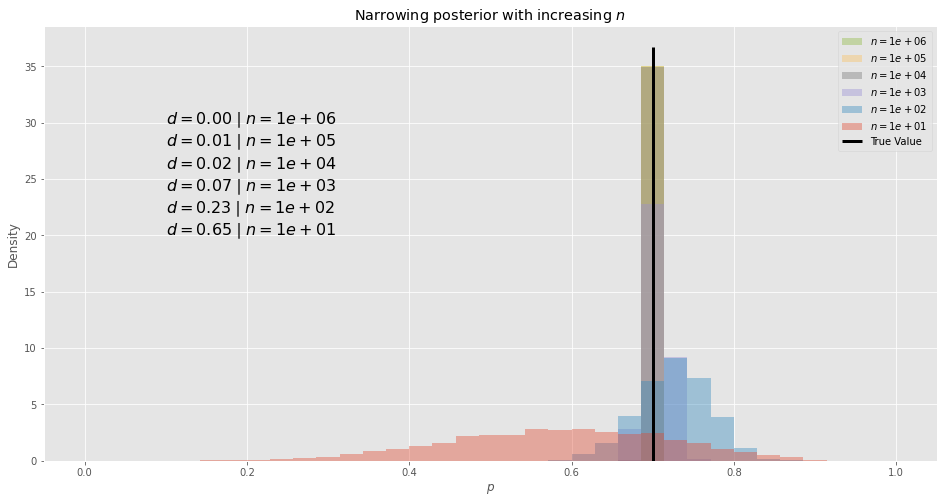

In [22]:
plt.hist(samples_list, stacked=False, density=True, bins=35, range=(0.0, 1.), 
         histtype='stepfilled', alpha=0.4,
         label=[f'$n={n:.0e}$ 'for n in n_trials]);

plt.vlines(p_true, *plt.gca().get_ylim(), label='True Value', lw=3)

plt.title('Narrowing posterior with increasing $n$')
plt.xlabel('$p$')
plt.ylabel('Density')
plt.legend();


from functools import reduce
text_list = [f"$d={reduce(lambda x, y: x - y, np.percentile(a=samples_list[i], q=[99.5, 0.5])):.2f}\
                 \mid n={n:.0e}$" for i, n in enumerate(n_trials)]
plt.text(x=0.1, y=20, s='\n'.join(reversed(text_list)), fontsize=16);